In [1]:
import os 
import tensorflow as tf
from tabulate import tabulate
from collections import defaultdict
import shutil
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from imagehash import average_hash
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from skimage.feature import hog
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc
from sklearn.utils import class_weight
from sklearn.utils import resample


from sklearn.utils import class_weight
from sklearn.utils import resample
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation, Input, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import VGG16
from tensorflow.keras.metrics import AUC, Precision, Recall



2025-07-23 08:44:57.660359: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753260297.836512      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753260297.892728      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
base_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/'
print(os.listdir(base_dir) if os.path.exists else "path is not found")
print(f"gpu is avaialble",tf.config.list_physical_devices('GPU'))

['val', '.DS_Store', 'test', 'train']
gpu is avaialble [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
train_dir = os.path.join(base_dir,"train")
val_dir = os.path.join(base_dir,"val")
test_dir = os.path.join(base_dir,"test")

In [4]:
# seeing the data set distribution in table
def no_of_images(directory):
    count=defaultdict(int)
    for root,dirs,files in os.walk(directory):
        class_name= os.path.basename(root)
        img_count = sum(file.lower().endswith(('.jpg','.png','.jpeg')) for file in files)
        if img_count>0:
            count[class_name] = img_count
    return dict(count)

train_counts = no_of_images(train_dir)
val_counts = no_of_images(val_dir)
test_counts = no_of_images(test_dir)

table =[['Train',train_counts.get('NORMAL',0),train_counts.get('PNEUMONIA',0),sum(train_counts.values())],
        ['val',val_counts.get('NORMAL',0),val_counts.get('PNEUMONIA',0),sum(val_counts.values())],
       ['Test',test_counts.get('NORMAL',0),test_counts.get('PNEUMONIA',0),sum(test_counts.values())],
       ["Total",train_counts.get('NORMAL',0)+val_counts.get('NORMAL',0)+test_counts.get('NORMAL',0),
        train_counts.get('PNEUMONIA',0)+val_counts.get('PNEUMONIA',0)+test_counts.get('PNEUMONIA',0),
         sum(train_counts.values())+sum(val_counts.values())+sum(test_counts.values())]]

print(tabulate(table,tablefmt = 'grid',headers=['Split','Normal','Pneumonia','Total'],numalign = 'center'))

+---------+----------+-------------+---------+
| Split   |  Normal  |  Pneumonia  |  Total  |
+=========+==========+=============+=========+
| Train   |   1341   |    3875     |  5216   |
+---------+----------+-------------+---------+
| val     |    8     |      8      |   16    |
+---------+----------+-------------+---------+
| Test    |   234    |     390     |   624   |
+---------+----------+-------------+---------+
| Total   |   1583   |    4273     |  5856   |
+---------+----------+-------------+---------+


### Dataset Distribution Analysis

The dataset shows significant class imbalance and split distribution issues:

1. **Class Imbalance**:
   - **Pneumonia cases dominate** (4,273) vs Normal (1,583)

2. **Split Problems**:
   - **Validation set is critically small** (only 16 images)
     - 8 Normal + 8 Pneumonia samples
     - Far below the recommended 10-20% of total data

3. **Training Implications**:
   - The tiny validation set **cannot provide reliable metrics**
   - High risk of **overfitting** with no meaningful validation
   - Model performance claims will be **statistically unreliable**

4. **Recommended Actions**:
   - **Redistribute splits** to get at least 500-1000 validation images
   - Consider **stratified k-fold cross-validation** instead of fixed splits
   - Apply **strong regularization** (dropout, L2, early stopping)
   - Use **class weights** to handle the imbalance

In [5]:

## As data set is imbalanced now combine all the images from the training  then split them by maintaining class balance

# new directory for copying data to the new location 
new_dest_dir='data_redistributed_stratified'
os.makedirs(new_dest_dir,exist_ok = True)
images = []
labels=[]

for class_name in ['NORMAL','PNEUMONIA'] :
    path = os.path.join(base_dir,'train',class_name)
    if os.path.exists(path):
        class_images = [ os.path.join(path,img_file) for img_file in os.listdir(path) 
                               if img_file.lower().endswith(('.jpg','.jpeg','.png')) ]
        images.extend(class_images)
        labels.extend([class_name]* len(class_images))

  #splitting the data with 70-15-15 for train-val-test respectively

x_train,x_temp,y_train,y_temp = train_test_split(
        images,labels,
        test_size = 0.3,
        random_state = 42,
        stratify= labels
         )

x_val,x_test,y_val,y_test = train_test_split(
        x_temp,y_temp,
        stratify = y_temp,
        random_state = 42,
        test_size = 0.5
        )
for split,images_list,labels_list in zip(['train','val','test'],[x_train,x_val,x_test],[y_train,y_val,y_test]):
    for images,labels in tqdm(zip(images_list,labels_list),desc=f"copying{split}",total = len(images_list)):
        folder_path = os.path.join(new_dest_dir,split,labels)
        os.makedirs(folder_path,exist_ok = True)
        shutil.copy(images,folder_path)
        
             
            





copyingtest: 100%|██████████| 783/783 [00:09<00:00, 83.86it/s]


In [6]:
from collections import Counter
print("Train:", Counter(y_train))
print("Val:", Counter(y_val))
print("Test:", Counter(y_test))


Train: Counter({'PNEUMONIA': 2712, 'NORMAL': 939})
Val: Counter({'PNEUMONIA': 581, 'NORMAL': 201})
Test: Counter({'PNEUMONIA': 582, 'NORMAL': 201})


In [7]:
#new base directory
new_base_dir= '/kaggle/working/data_redistributed_stratified'

new_train_dir = os.path.join(new_base_dir,"train")
new_val_dir = os.path.join(new_base_dir,"val")
new_test_dir = os.path.join(new_base_dir,"test")

In [47]:
#visualizing the distribution of the new dataset


def no_of_images(directory):
    count=defaultdict(int)
    for root,dirs,files in os.walk(directory):
        class_name= os.path.basename(root)
        img_count = sum(file.lower().endswith(('.jpg','.png','.jpeg')) for file in files)
        if img_count>0:
            count[class_name] = img_count
    return dict(count)

train_counts = no_of_images(new_train_dir)
val_counts = no_of_images(new_val_dir)
test_counts = no_of_images(new_test_dir)

table =[['Train',train_counts.get('NORMAL',0),train_counts.get('PNEUMONIA',0),sum(train_counts.values())],
        ['val',val_counts.get('NORMAL',0),val_counts.get('PNEUMONIA',0),sum(val_counts.values())],
       ['Test',test_counts.get('NORMAL',0),test_counts.get('PNEUMONIA',0),sum(test_counts.values())],
       ["Total",train_counts.get('NORMAL',0)+val_counts.get('NORMAL',0)+test_counts.get('NORMAL',0),
        train_counts.get('PNEUMONIA',0)+val_counts.get('PNEUMONIA',0)+test_counts.get('PNEUMONIA',0),
         sum(train_counts.values())+sum(val_counts.values())+sum(test_counts.values())]]

print(tabulate(table,tablefmt = 'grid',headers=['Split','Normal','Pneumonia','Total'],numalign = 'center'))

+---------+----------+-------------+---------+
| Split   |  Normal  |  Pneumonia  |  Total  |
+=========+==========+=============+=========+
| Train   |   985    |    2784     |  3769   |
+---------+----------+-------------+---------+
| val     |   201    |     581     |   782   |
+---------+----------+-------------+---------+
| Test    |   201    |     582     |   783   |
+---------+----------+-------------+---------+
| Total   |   1387   |    3947     |  5334   |
+---------+----------+-------------+---------+


In [8]:
#checking for the duplicate values in the splits to avoid the data leakage in data splits

def get_hashes(directory):
    """"This function will give the hashes list which consists of average hashes of all images"""
    hashes=[]
    for root,_,files in os.walk(directory):
        class_name = os.path.basename(root)
        for file in files:
            if file.lower().endswith(('.jpg','.jpeg','.png')):
                try:
                    
                    image_path = os.path.join(directory,class_name,file)
                    with Image.open(image_path) as img:
                        hashes.append(average_hash(img))
                except Exception as e:
                    print(f"Error processing: {image_path}:{str(e)}")
    return hashes


train_hashes = get_hashes(new_train_dir)
val_hashes = get_hashes(new_val_dir)
test_hashes = get_hashes(new_test_dir)
print(train_hashes[0])


# Find duplicates
duplicates_tr_v = set(train_hashes) & set(val_hashes)
print(f"Number of duplicate images between train and validation found: {len(duplicates_tr_v)}")
duplicates_tr_t = set(train_hashes) & set(test_hashes)
print(f"Number of duplicate images between train and test found: {len(duplicates_tr_t)}")
duplicates_v_t = set(val_hashes) & set(test_hashes)
print(f"Number of duplicate images between validation and test found: {len(duplicates_v_t)}")

3c387c7c5e1c7c7e
Number of duplicate images between train and validation found: 38
Number of duplicate images between train and test found: 48
Number of duplicate images between validation and test found: 12


In [9]:
#we have identified the duplicates in the given splits so now we move them to the train data from the val and test data 
unique_hashes = set()

#first the process the training data and copy the hashes of the training data to unique_hashes set
for class_name in ['NORMAL','PNEUMONIA']:
    class_path = os.path.join(new_train_dir,class_name)
    for img_file in os.listdir(class_path):
        img_path = os.path.join(class_path,img_file)
        try:
            with Image.open(img_path) as img_obj:
                unique_hashes.add(str(average_hash(img_obj)))
        except: 
            continue
#now process the val and test data and move duplicates from them to the train data
for split in [new_val_dir,new_test_dir]:
    for class_name in ['NORMAL','PNEUMONIA']:
        class_path = os.path.join(split,class_name)
        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path,img_file)
            try:
                with Image.open(img_path) as img_obj:
                    hash = str(average_hash(img_obj))
                    unique_hashes.add(hash) if hash not in unique_hashes else shutil.move(img_path,os.path.join(new_train_dir,class_name))
            except: 
                continue
            
    

In [10]:
def no_of_images(directory):
    count=defaultdict(int)
    for root,dirs,files in os.walk(directory):
        class_name= os.path.basename(root)
        img_count = sum(file.lower().endswith(('.jpg','.png','.jpeg')) for file in files)
        if img_count>0:
            count[class_name] = img_count
    return dict(count)

train_counts = no_of_images(new_train_dir)
val_counts = no_of_images(new_val_dir)
test_counts = no_of_images(new_test_dir)

table =[['Train',train_counts.get('NORMAL',0),train_counts.get('PNEUMONIA',0),sum(train_counts.values())],
        ['val',val_counts.get('NORMAL',0),val_counts.get('PNEUMONIA',0),sum(val_counts.values())],
       ['Test',test_counts.get('NORMAL',0),test_counts.get('PNEUMONIA',0),sum(test_counts.values())],
       ["Total",train_counts.get('NORMAL',0)+val_counts.get('NORMAL',0)+test_counts.get('NORMAL',0),
        train_counts.get('PNEUMONIA',0)+val_counts.get('PNEUMONIA',0)+test_counts.get('PNEUMONIA',0),
         sum(train_counts.values())+sum(val_counts.values())+sum(test_counts.values())]]

print(tabulate(table,tablefmt = 'grid',headers=['Split','Normal','Pneumonia','Total'],numalign = 'center'))

+---------+----------+-------------+---------+
| Split   |  Normal  |  Pneumonia  |  Total  |
+=========+==========+=============+=========+
| Train   |   985    |    2784     |  3769   |
+---------+----------+-------------+---------+
| val     |   181    |     551     |   732   |
+---------+----------+-------------+---------+
| Test    |   175    |     540     |   715   |
+---------+----------+-------------+---------+
| Total   |   1341   |    3875     |  5216   |
+---------+----------+-------------+---------+


In [51]:
def count_images(directory):
    count = 0
    for root, _, files in os.walk(directory):
        count += len([f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
    return count

print("Training images:", count_images(new_train_dir))
print("Validation images:", count_images(new_val_dir))
print("Test images:", count_images(new_test_dir))

# # Get the new distributions
# print('Train:', get_class_distribution(train_dir))
# print('Validation:',get_class_distribution(val_dir))
# print('Test:',get_class_distribution(test_dir))

Training images: 3786
Validation images: 769
Test images: 779


# Image Analysis Summary

### Basic Statistics
- **Average Image Size**: 1126.84 (width) X 1465.32 (height) pixels  
- **Pixel Value Distribution**:  
  - **Mean**: 124.6  
  - **Standard Deviation**: 63.4  

### Observations
- The histogram shows pixel values ranging from 0 to 255, with counts distributed across intensities.  
- The mean pixel value (124.6) suggests a balanced distribution, while the standard deviation (63.4) indicates moderate variability in pixel intensities.  

### Potential Insights
- The image dimensions are relatively large, which may imply high resolution or detailed content.  
- The pixel value distribution could be further analyzed to identify dominant intensity ranges or patterns.


In [11]:
#seeing data distribution and creating distribution directories

print(train_counts,val_counts,test_counts)

{'PNEUMONIA': 2784, 'NORMAL': 985} {'PNEUMONIA': 551, 'NORMAL': 181} {'PNEUMONIA': 540, 'NORMAL': 175}


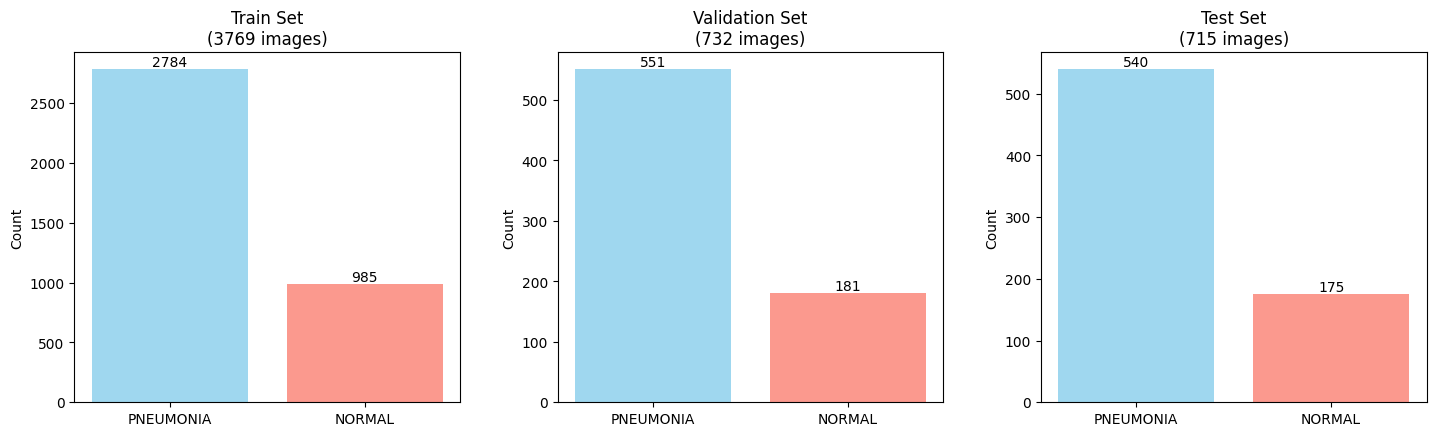

In [12]:
# Class Distribution Visualization 
plt.figure(figsize=(15, 5))

# Create subplots
for i, (name, dist) in enumerate(zip(['Train', 'Validation', 'Test'], 
                                   [train_counts,val_counts,test_counts]), 1):
    plt.subplot(1, 3, i)
    bars = plt.bar(dist.keys(), dist.values(), color=['skyblue', 'salmon'], alpha=0.8)
    plt.title(f'{name} Set\n({sum(dist.values())} images)')
    plt.ylabel('Count')
    
    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}',
                ha='center', va='bottom', fontsize=10)

plt.tight_layout(pad=3.0)  # Add extra padding between subplots
plt.show()

### Traning Phase Frist train the model using the HOG+RANDOM FOREST CLASSIFIER

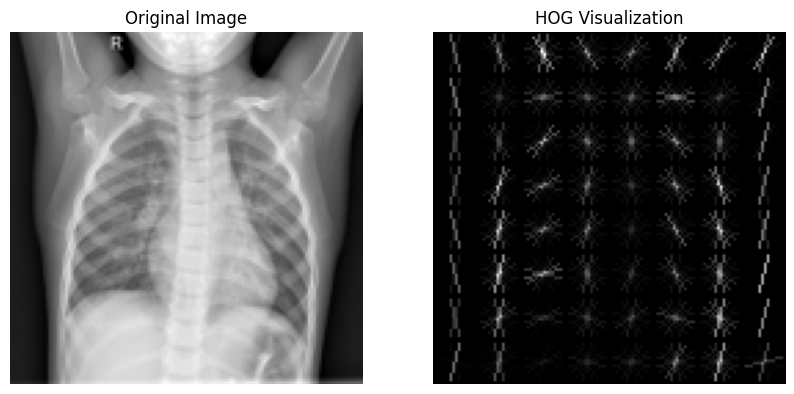

<class 'numpy.ndarray'>


In [54]:
# SAMPLE  OF HOW HOG EXTRACT THE ORIGINAL IMAGE

def visualize_hog(image_path, resize_dim=(128, 128)):
    # Load and preprocess image
    img = Image.open(image_path).convert('L')  # Convert to grayscale
    img = img.resize(resize_dim)
    img_array = np.array(img)

    # Extract HOG features with visualization enabled
    fd, hog_image = hog(
        img_array,
        orientations=8,
        pixels_per_cell=(16, 16),
        cells_per_block=(1, 1),
        visualize=True,
        block_norm='L2-Hys'
    )

    # Plot original and HOG image side by side
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.title('Original Image')
    plt.imshow(img_array, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title('HOG Visualization')
    plt.imshow(hog_image, cmap='gray')
    plt.axis('off')

    plt.show()
    print(type(fd))
visualize_hog(os.path.join(new_train_dir,'NORMAL','IM-0115-0001.jpeg'))



In [55]:
def extract_hog(img_path,reduce_dimension = (128,128)):
    img = Image.open(img_path).convert('L')
    img = img.resize(reduce_dimension)
    img = np.array(img)


    features,hog_img = hog(
        img,
        orientations = 8,
        pixels_per_cell = (16,16),
        cells_per_block = (1,1),
        visualize = True
    )
    return features


def img_to_hog_img(directory):
    x=[]
    y=[]
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory,class_name)
        if not  os.path.isdir(class_path):
            continue
        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path,img_file)
            hog_array= extract_hog(img_path)
            x.append(hog_array)
            y.append(0 if class_name == 'NORMAL' else 1)

    return np.array(x),np.array(y)

#building training and testing data from the data we get from the img_to_hog_img function
print(new_train_dir,new_test_dir)

x_train,y_train = img_to_hog_img(new_train_dir)

x_test,y_test = img_to_hog_img(new_test_dir)         


/kaggle/working/data_redistributed_stratified/train /kaggle/working/data_redistributed_stratified/test


`HOG Feature Extraction for Classical ML`

**Key Components:**
1. `extract_hog_features()` Function:
   - Converts images to grayscale (`'L'` mode)
   - Resizes to consistent dimensions (default 128×128)
   - Computes Histogram of Oriented Gradients (HOG) features with:
     
2. `prepare_classical_ml_data()` Function:
   - Processes directory structure to:
     - Extract HOG features per image
     - Assign labels (0 for `NORMAL`, 1 for `PNEUMONIA`)
   - Returns feature matrix `X` and label vector `y`

`HOG Parameters Explained:`
| Parameter          | Value    | Effect                                                                 |
|--------------------|----------|-----------------------------------------------------------------------|
| `orientations`     | 8        | Number of gradient orientation bins (trade-off between detail and dimensionality) |
| `pixels_per_cell`  | (16,16)  | Smaller values capture finer details but increase feature size        |
| `cells_per_block`  | (1,1)    | No block normalization (simpler features)                             |


`Key Advantages for Pneumonia Detection`

1. **Shape and Texture Sensitivity**
   - HOG excels at capturing **edge patterns** and **local shape information**
   - Critical for detecting:
     - Pulmonary infiltrates (pneumonia)
     - Alveolar patterns
     - Bronchial wall thickening

2. **Illumination Invariance**
   - Normalizes gradients → robust to:
     - X-ray exposure variations
     - Scanner differences
     - Contrast fluctuations

3. **Dimensionality Efficiency**
    - The configuration (512 features) is:
     - **Rich enough**: Captures pulmonary pathology signatures
     - **Compact enough**: Avoids curse of dimensionality vs. raw pixels (16,384 for 128×128)

4. **Clinical Interpretability**
   - Visualizing HOG features shows:
     - Where the model detects important edges

In [56]:
#Loading Rf and training model using the  random forest classifier

RandomForest = RandomForestClassifier(n_estimators = 100,random_state = 42)
RandomForest.fit(x_train,y_train)
#making predictions
y_pred = RandomForest.predict(x_test)


In [57]:
print(f"The accuracy of the model is {accuracy_score(y_test,y_pred)}") 

The accuracy of the model is 0.9640564826700898


### NOW TRAINING THE MODEL USING THE CUSTOM CNN MODEL 
-  AS THE PNEUMONIA EXAMPLES IN THE DATA DOMINATES THE NORMAL EXAMPLES WE HAVE TO DO DATA AUGUMENTATION AND CLASS WEIGHTS BALANCING TECHNIQUES


In [58]:
#DATA AUGUMENTATION
img_height, img_width = 320, 320 # decided that based on the statistics we produced above
batch_size = 32
input_shape = (img_height, img_width, 1)

train_gen = ImageDataGenerator(
      rescale=1./255,
    rotation_range=8, 
    width_shift_range=0.05,  
    height_shift_range=0.05,
    zoom_range=0.05,  
    shear_range = 0.05,
    brightness_range=[0.95, 1.05],  
    horizontal_flip=True,
    fill_mode='nearest'
    
)

val_and_test_gen = ImageDataGenerator(rescale = 1./255)

train_generator = train_gen.flow_from_directory(
    new_train_dir,
    target_size = (img_height,img_width),
    batch_size = batch_size,
    color_mode='grayscale',
    class_mode='binary',
    shuffle=True,
    seed=42
    
)



val_generator = val_and_test_gen.flow_from_directory(
    new_val_dir,
    target_size = (img_height,img_width),
    batch_size = batch_size,
    class_mode='binary',
    color_mode='grayscale',
    shuffle=False
    
)

test_generator = val_and_test_gen.flow_from_directory(
    new_test_dir,
    target_size = (img_height,img_width),
    batch_size = batch_size,
    class_mode='binary',
    color_mode='grayscale',
    shuffle=False
    
)



Found 3786 images belonging to 2 classes.
Found 769 images belonging to 2 classes.
Found 779 images belonging to 2 classes.


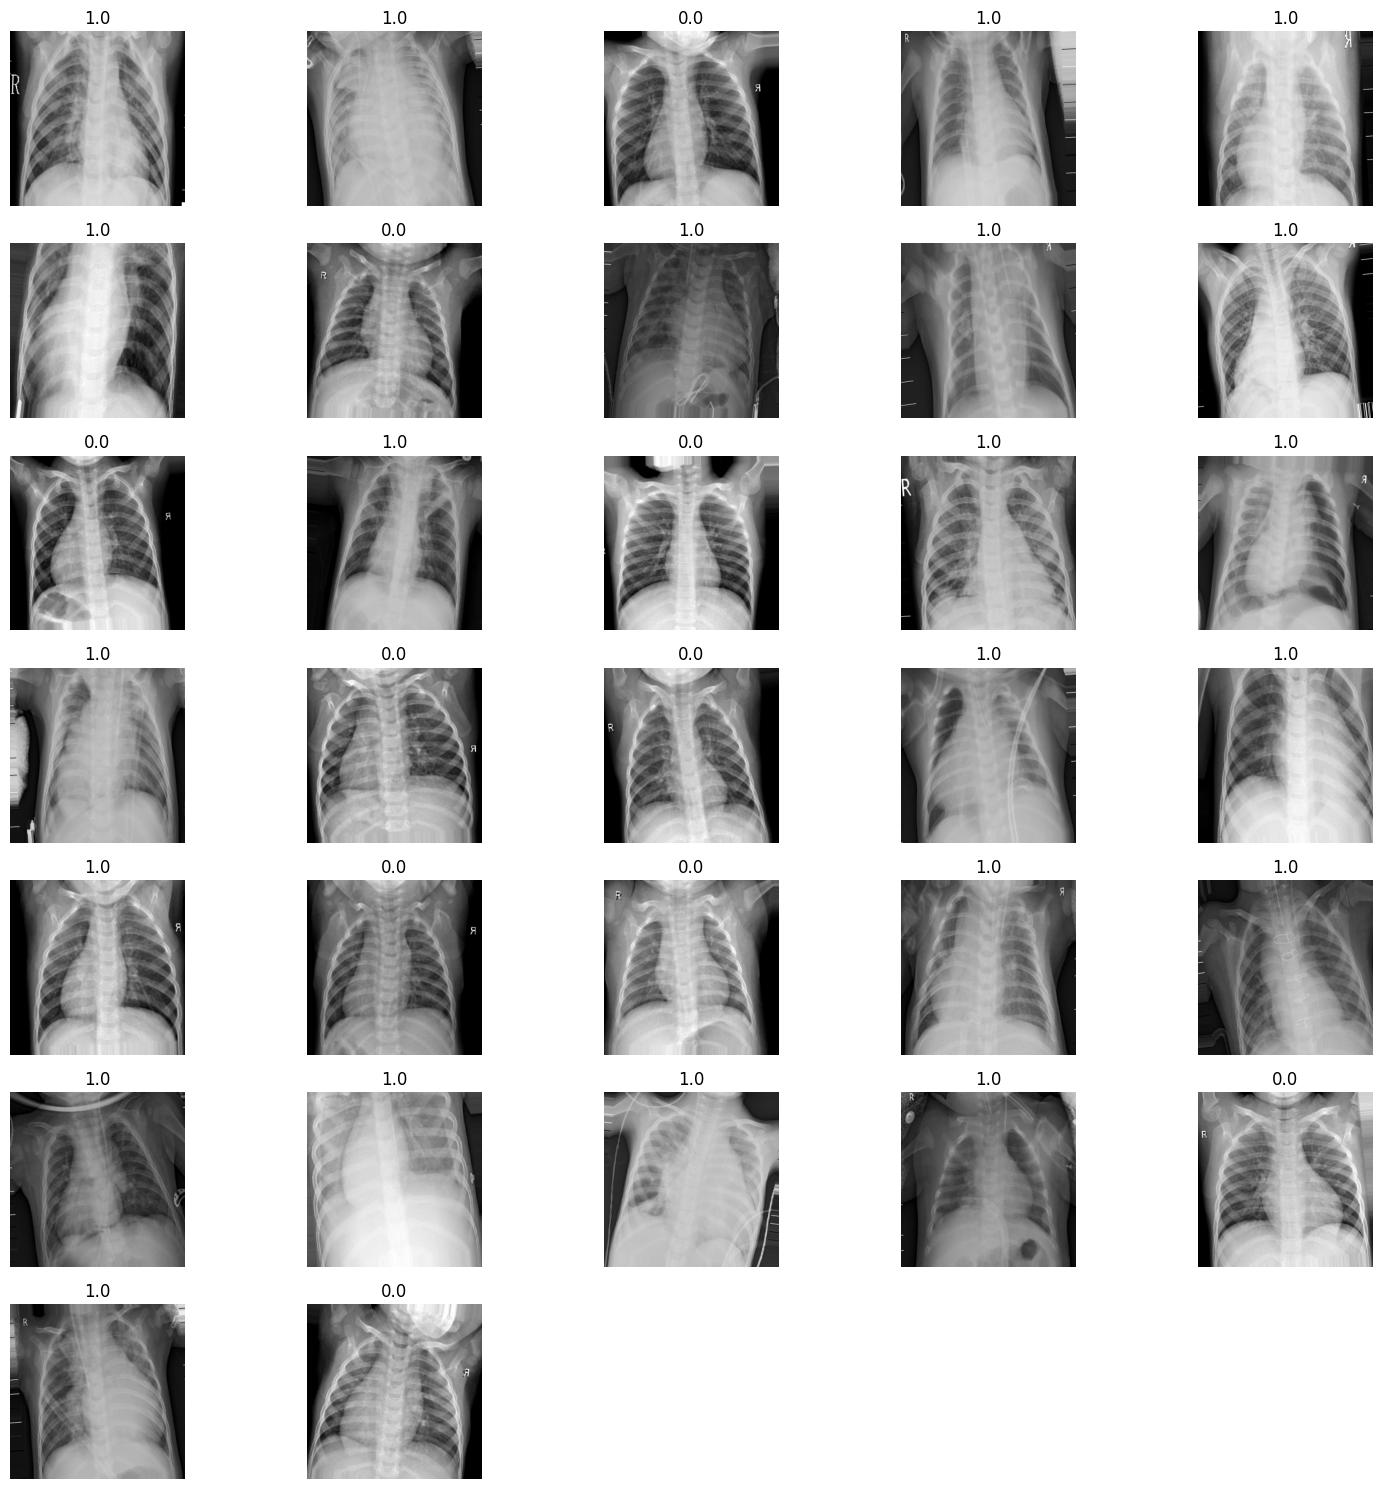

In [59]:
# Plot some images to ensure that the augmentation does NOT change the pics too much
x_batch, y_batch = next(train_generator)

plt.figure(figsize=(15,15))
for i in range(32):
    img = x_batch[i].squeeze()
    label = y_batch[i]
    
    plt.subplot(7, 5, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(label)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [60]:
#  # as we are using custom generator and combing them it doesnt have .classes attribute which is used in computing class weights so we have to 
# # compute class labels manually and then use them to compute classweights


# normal_dir = os.path.join(new_train_dir, 'NORMAL')
# pneumonia_dir = os.path.join(new_train_dir, 'PNEUMONIA')

# num_normal = len(os.listdir(normal_dir))
# num_pneumonia = len(os.listdir(pneumonia_dir))

# print(f"NORMAL: {num_normal}, PNEUMONIA: {num_pneumonia}")
# import numpy as np
# from sklearn.utils import class_weight

# # 0 → NORMAL, 1 → PNEUMONIA
# y_train_labels = [0] * num_normal + [1] * num_pneumonia
# y_train_labels = np.array(y_train_labels)




In [22]:
# Compute class weights
y_train_labels  = train_generator.classes
class_weights = class_weight.compute_class_weight(
    class_weight = 'balanced',
    classes = np.unique(y_train_labels),
    y = y_train_labels
    )
class_weight_dict = dict(enumerate(class_weights))
print("class weights:",class_weight_dict)

class weights: {0: 1.9131979695431471, 1: 0.6769037356321839}


### **BUILDING A CUSTOM CNN MODEL**

In [79]:
# Build Model with Batch Normalization

from tensorflow.keras.layers import GlobalAveragePooling2D

cnn_model = Sequential([
    # Feature extraction
    Conv2D(16, (3, 3), padding='same', input_shape=(img_height, img_width, 1), kernel_regularizer=regularizers.l2(0.0005)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    
    Dropout(0.5),
    GlobalAveragePooling2D(),
    Dense(32),
    BatchNormalization(),
    Activation("relu"),
    Dropout(0.5),
    Dense(1, activation="sigmoid")
])
    

cnn_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 320, 320, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 320, 320, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 320, 320, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 160, 160, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 160, 160, 64)   │         9,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 160, 160, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 160, 160, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 80, 80, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 80, 80, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 80, 80, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 80, 80, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 40, 40, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 40, 40, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 88,417 (345.38 KB)

 Trainable params: 87,937 (343.50 KB)

 Non-trainable params: 480 (1.88 KB)

In [80]:
# Compile Model
cnn_model.compile(
    optimizer=Adam(learning_rate=1e-4), 
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        AUC(name='auc'),
        Precision(name='precision'),
        Recall(name='recall')
    ]
)
cnn_callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        mode='min',
        restore_best_weights=True,
        min_delta=0.005
    ),
    ModelCheckpoint(
        'best_weights.keras',
        monitor='val_auc',  
        save_best_only=True,
        mode='max'
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    )
]


`Custom CNN Model Architecture`

- Input: Grayscale images with shape (height, width, 1).
- Three convolutional blocks with Conv2D layers (16, 64, 128 filters), each followed by Batch Normalization, ReLU activation, and MaxPooling.
- Dropout (0.3) after the last convolution block for regularization.
- Flatten layer to convert 3D features to 1D vector.
- Dense layer with 32 units, L2 regularization, Batch Normalization, ReLU activation, and Dropout (0.5).
- Output layer with softmax function for categorical classification.
- Compiled with Adam optimizer, categorical cross-entropy loss, and accuracy metric.
- Callbacks include early stopping, model checkpointing (monitoring validation AUC), and learning rate reduction on plateau.


In [64]:
# Steps per epoch: total training samples // batch_size
steps_per_epoch = len(train_generator)
validation_steps = len(val_generator)
print(steps_per_epoch,validation_steps)

119 25


In [87]:
for images, labels in train_generator:
    print(images.shape)  # should be (batch_size, 320, 320, 1)
    break


(32, 320, 320, 1)


In [81]:

# Train model
history = cnn_model.fit(
    train_generator,  # your combined generator
    validation_data=val_generator,
    epochs=30,
    class_weight = class_weight_dict,
    callbacks=cnn_callbacks,
    verbose=1
)
print("Training complete.")


Epoch 1/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 62s 455ms/step - accuracy: 0.6339 - auc: 0.7973 - loss: 0.6195 - precision: 0.9261 - recall: 0.5296 - val_accuracy: 0.7477 - val_auc: 0.5903 - val_loss: 0.5663 - val_precision: 0.7477 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 2/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 49s 412ms/step - accuracy: 0.7745 - auc: 0.9272 - loss: 0.4254 - precision: 0.9750 - recall: 0.7115 - val_accuracy: 0.7477 - val_auc: 0.5574 - val_loss: 0.7599 - val_precision: 0.7477 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 3/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 49s 411ms/step - accuracy: 0.8208 - auc: 0.9340 - loss: 0.3903 - precision: 0.9784 - recall: 0.7703 - val_accuracy: 0.7477 - val_auc: 0.6181 - val_loss: 0.7564 - val_precision: 0.7477 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 4/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 49s 409ms/step - accuracy: 0.8410 - auc: 0.9483 - loss: 0.3448 - precision: 0.9824 - recall: 0.7987 - val_accuracy: 0.7659 - val_auc: 0.9066 

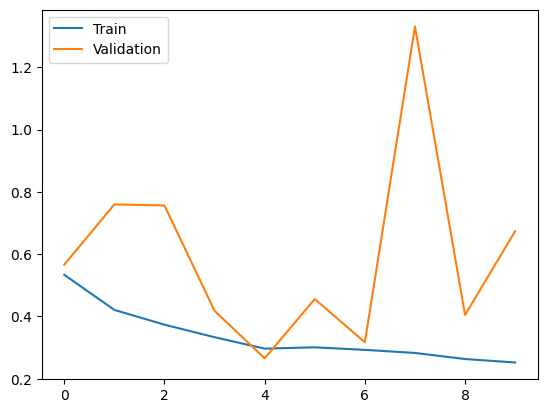

In [89]:

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train', 'Validation'])
plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

y_pred = cnn_model.predict(val_generator)         
y_pred_classes = np.argmax(y_pred, axis=1)  # if categorical
# y_pred_classes = (y_pred > 0.5).astype("int32")  # if binary classification

y_true = val_generator.classes

print(confusion_matrix(y_true, y_pred_classes))
print(classification_report(y_true, y_pred_classes))

In [83]:
y_pred = cnn_model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
print(confusion_matrix(y_test, y_pred_classes))
print(classification_report(y_test, y_pred_classes))

25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 176ms/step
[[198   0]
 [581   0]]
              precision    recall  f1-score   support

           0       0.25      1.00      0.41       198
           1       0.00      0.00      0.00       581

    accuracy                           0.25       779
   macro avg       0.13      0.50      0.20       779
weighted avg       0.06      0.25      0.10       779



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [68]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# Ensure steps match the total number of test samples
steps = int(np.ceil(test_generator.samples / test_generator.batch_size))

y_pred = cnn_model.predict(test_generator, steps=steps, verbose=1)

# Get predicted class indices
y_pred_classes = np.argmax(y_pred, axis=1)

# Get true labels from the generator
y_true = test_generator.classes  # automatically set by flow_from_directory

print(confusion_matrix(y_true, y_pred_classes))
print(classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys()))


25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 172ms/step
[[198   0]
 [581   0]]
              precision    recall  f1-score   support

      NORMAL       0.25      1.00      0.41       198
   PNEUMONIA       0.00      0.00      0.00       581

    accuracy                           0.25       779
   macro avg       0.13      0.50      0.20       779
weighted avg       0.06      0.25      0.10       779



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [69]:
train_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [70]:
print("Class indices:", test_generator.class_indices)


Class indices: {'NORMAL': 0, 'PNEUMONIA': 1}


In [71]:
from collections import Counter
y_test = test_generator.classes
print("Sample test labels:", y_test[:10])
print("Label distribution:", Counter(y_test))


Sample test labels: [0 0 0 0 0 0 0 0 0 0]
Label distribution: Counter({1: 581, 0: 198})


In [72]:
print("Test generator class distribution:", Counter(test_generator.classes))

Test generator class distribution: Counter({1: 581, 0: 198})


In [73]:
# Good check
print(train_generator.class_indices)  # Should print: {'NORMAL': 0, 'PNEUMONIA': 1}
print(train_generator.classes[:10])  

{'NORMAL': 0, 'PNEUMONIA': 1}
[0 0 0 0 0 0 0 0 0 0]


In [74]:
train_generator.classes



array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [75]:
batch_x, batch_y = next(train_generator)
print("Sample labels:", batch_y[:10])

Sample labels: [1. 1. 0. 1. 1. 1. 1. 1. 0. 1.]


In [78]:



preds = cnn_model.predict(test_generator, verbose=1)
print("Raw sigmoid outputs:", preds[:10].ravel())
print("Rounded predictions:", (preds[:10] > 0.5).astype(int).ravel())


25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 177ms/step
Raw sigmoid outputs: [7.9456242e-03 3.7418116e-02 8.9983689e-04 7.2832547e-02 1.8387256e-04
 6.2818606e-03 2.8731099e-03 7.5907505e-04 4.4524764e-05 2.0730292e-02]
Rounded predictions: [0 0 0 0 0 0 0 0 0 0]


In [84]:
np.unique(y_train, return_counts=True)


(array([0, 1]), array([ 995, 2791]))

In [86]:
# Show this part
print(y_train[:20])
print([img.shape for img in x_train[:5]])

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[(512,), (512,), (512,), (512,), (512,)]


## **Training on the pretrained model vgg 16 using the Transfer learning**

In [14]:
#DATA AUGUMENTATION
img_height, img_width = 320, 320 # decided that based on the statistics we produced above
batch_size = 32
input_shape = (img_height, img_width, 1)

train_gen = ImageDataGenerator(
      rescale=1./255,
    rotation_range=8, 
    width_shift_range=0.05,  
    height_shift_range=0.05,
    zoom_range=0.05,  
    shear_range = 0.05,
    brightness_range=[0.95, 1.05],  
    horizontal_flip=True,
    fill_mode='nearest'
    
)

val_and_test_gen = ImageDataGenerator(rescale = 1./255)

train_generator = train_gen.flow_from_directory(
    new_train_dir,
    target_size = (img_height,img_width),
    batch_size = batch_size,
    color_mode='rgb',
    class_mode='binary',
    shuffle=True,
    seed=42
    
)



val_generator = val_and_test_gen.flow_from_directory(
    new_val_dir,
    target_size = (img_height,img_width),
    batch_size = batch_size,
    class_mode='binary',
    color_mode='rgb',
    shuffle=False
    
)

test_generator = val_and_test_gen.flow_from_directory(
    new_test_dir,
    target_size = (img_height,img_width),
    batch_size = batch_size,
    class_mode='binary',
    color_mode='rgb',
    shuffle=False
    
)



Found 3769 images belonging to 2 classes.
Found 732 images belonging to 2 classes.
Found 715 images belonging to 2 classes.


In [16]:
 # importing the pretrained model without top classification layer 

vgg16_model = VGG16(weights='imagenet',include_top = False,
                    input_shape =(img_height,img_width,3))
vgg16_model.trainable = False

inputs = Input(shape=(img_height,img_width,3))
x = vgg16_model(inputs,training = False)
x = GlobalAveragePooling2D()(x)
x = Dense(128,activation = 'relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
output = Dense(1,activation = 'sigmoid')(x)

vgg_model = Model(inputs = inputs, outputs = output)



In [18]:
#compiling the model
vgg_model.compile(
     optimizer=Adam(learning_rate = 1e-4),
     loss = 'binary_crossentropy',
     metrics = ['accuracy']
     )

In [19]:
# Set up callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ModelCheckpoint('vgg16_best_model.h5', monitor='val_loss', save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)
]

vgg_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 320, 320, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 10, 10, 512)    │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,780,993 (56.39 MB)

 Trainable params: 66,049 (258.00 KB)

 Non-trainable params: 14,714,944 (56.13 MB)

In [24]:
#Training the model 
print("------vgg 16 model training is started.-----")
vgg_model.fit(
    train_generator,
    validation_data = val_generator,
    epochs = 20,
    callbacks = callbacks,
    class_weight = class_weight_dict,
    verbose = 1
    
)
print("--- VGG16 Model Training Finished ---")

------vgg 16 model training is started.-----


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


I0000 00:00:1753262111.076114     146 service.cc:148] XLA service 0x7d5394010920 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753262111.076912     146 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1753262111.549956     146 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/118 ━━━━━━━━━━━━━━━━━━━━ 39:48 20s/step - accuracy: 0.5938 - loss: 0.5752

I0000 00:00:1753262127.752649     146 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 63/118 ━━━━━━━━━━━━━━━━━━━━ 52s 957ms/step - accuracy: 0.6620 - loss: 0.5772

E0000 00:00:1753262193.719562     147 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1753262193.958728     147 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1753262195.505275     147 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1753262195.769002     147 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6959 - loss: 0.5260

E0000 00:00:1753262266.363171     148 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1753262266.603784     148 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1753262268.529234     148 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1753262268.794707     148 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.



Epoch 1: val_loss improved from inf to 0.56397, saving model to vgg16_best_model.h5
118/118 ━━━━━━━━━━━━━━━━━━━━ 165s 1s/step - accuracy: 0.6964 - loss: 0.5253 - val_accuracy: 0.9139 - val_loss: 0.5640 - learning_rate: 1.0000e-04
Epoch 2/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 955ms/step - accuracy: 0.8212 - loss: 0.3470
Epoch 2: val_loss improved from 0.56397 to 0.46017, saving model to vgg16_best_model.h5
118/118 ━━━━━━━━━━━━━━━━━━━━ 121s 1s/step - accuracy: 0.8214 - loss: 0.3468 - val_accuracy: 0.9372 - val_loss: 0.4602 - learning_rate: 1.0000e-04
Epoch 3/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 959ms/step - accuracy: 0.8689 - loss: 0.2739
Epoch 3: val_loss improved from 0.46017 to 0.39904, saving model to vgg16_best_model.h5
118/118 ━━━━━━━━━━━━━━━━━━━━ 121s 1s/step - accuracy: 0.8689 - loss: 0.2738 - val_accuracy: 0.9057 - val_loss: 0.3990 - learning_rate: 1.0000e-04
Epoch 4/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 956ms/step - accuracy: 0.8865 - loss: 0.2565
Epoch 4: val_loss improved from 0.399

In [26]:
# Evaluate Model on Test Set
print("\n--- Evaluating the VGG16 model on the test set ---")
test_loss, test_accuracy = vgg_model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


--- Evaluating the VGG16 model on the test set ---
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 315ms/step - accuracy: 0.9362 - loss: 0.2072
Test Loss: 0.2549
Test Accuracy: 0.9148


22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step

E0000 00:00:1753264186.192767     147 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1753264186.427291     147 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1753264187.339563     147 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1753264187.597728     147 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


23/23 ━━━━━━━━━━━━━━━━━━━━ 14s 570ms/step
              precision    recall  f1-score   support

      NORMAL       0.76      0.95      0.84       175
   PNEUMONIA       0.98      0.90      0.94       540

    accuracy                           0.91       715
   macro avg       0.87      0.93      0.89       715
weighted avg       0.93      0.91      0.92       715



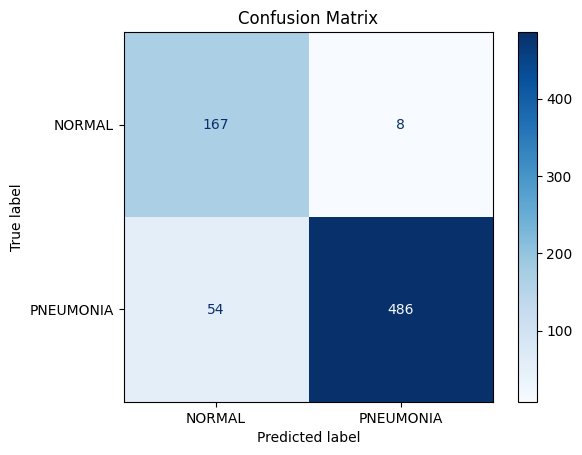

In [28]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import numpy as np
import matplotlib.pyplot as plt

# Predictions
y_pred_probs = vgg_model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1) if y_pred_probs.shape[1] > 1 else (y_pred_probs > 0.5).astype("int32")
y_true = test_generator.classes

# Classification Report
class_labels = list(test_generator.class_indices.keys())
print(classification_report(y_true, y_pred, target_names=class_labels))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix")
plt.show()


In [30]:
# Save Final Model
vgg_model.save('final_vgg_model.h5')
print("Final VGG16 model saved as final_vgg_model.h5")

Final VGG16 model saved as final_vgg_model.h5
